In [1]:
%qtconsole

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from scipy import signal

## Extract Lamp Mean brightness for each frame of video capture

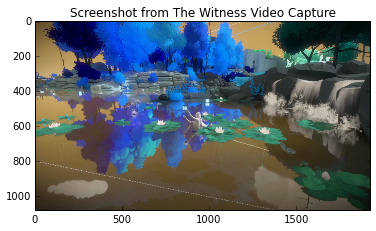

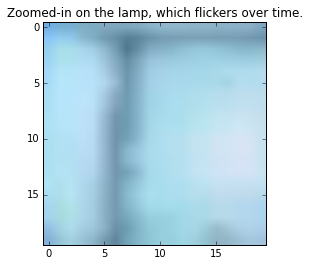

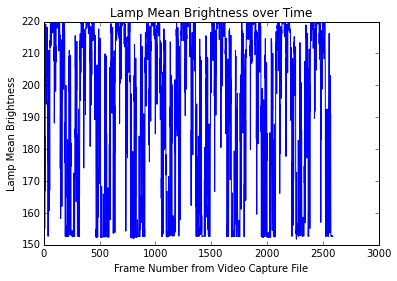

In [22]:
filename = "lampflicker2.mp4"


cap = cv2.VideoCapture(filename)
ret, frame = cap.read()
# frame_zoomed = frame[483:500, 925:945, :]
frame_zoomed = frame[490:510, 845:865, :]
fig, ax = plt.subplots()
plt.imshow(frame)
plt.title('Screenshot from The Witness Video Capture')

fig, ax = plt.subplots()
plt.title('Zoomed-in on the lamp, which flickers over time.')
plt.imshow(frame_zoomed)

lamp = []
while True:
    ret, frame = cap.read()
    if not ret:
        cap.release()
        break
    else:
#         lamp_brightness = np.mean(frame[483:500, 925:945, :])
        lamp_brightness = np.mean(frame[490:510, 845:865, :])
        lamp.append(lamp_brightness)
        
fig, ax = plt.subplots()
plt.plot(lamp)
plt.title('Lamp Mean Brightness over Time')    
plt.ylabel('Lamp Mean Brightness')
plt.xlabel('Frame Number from Video Capture File')



## Do some basic Analysis

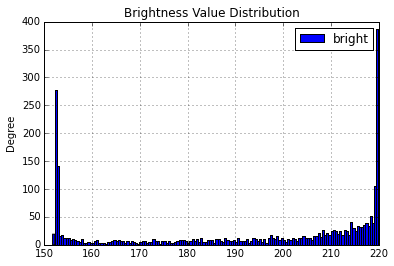

In [23]:
data = pd.DataFrame(data=lamp, columns=['bright'])

data.plot(kind='hist', bins=150, title='Brightness Value Distribution')



## Get Length of time that the lamp is on for.  If it is morse code, we'll see two length clusters

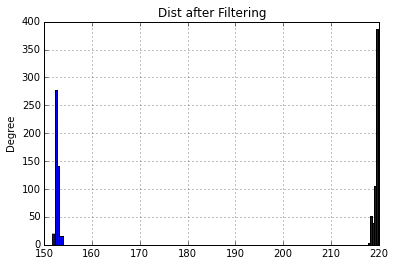

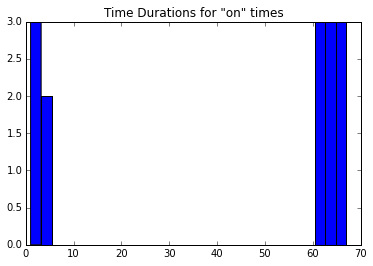

In [25]:
data['on'] = data['bright'] > 218
data['off'] = data['bright'] < 154

fdata = data.loc[data['on'] | data['off']]
fdata['bright'].plot(kind='hist', bins=150, title='Dist after Filtering')


ii = itertools.groupby(fdata['on'].values)
durs = [sum(gg[1]) for gg in ii if gg[0]]
fig, ax = plt.subplots()
plt.hist(durs, bins=30)
plt.title('Time Durations for "on" times')

Okay, maybe not morse code (at least, it doesn't seem all that clear.)

## Maybe the signal is repeating

290


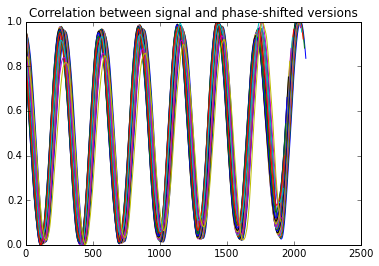

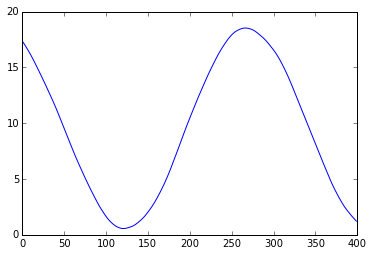

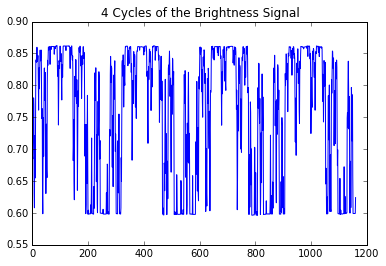

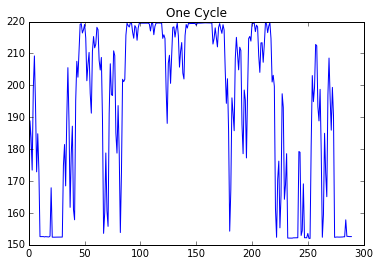

In [28]:
dd = data['bright'].values
corrs_sum = np.zeros(400)
conv_win = 100
dd_convd = np.convolve(dd, np.ones(conv_win), mode='valid')
for winlen in range(400, 600, 10):
    corrs = signal.correlate(dd_convd, dd_convd[:winlen], 'valid')
    corrs_normed = (corrs-corrs.min()) / (corrs.max() - corrs.min())
    plt.plot(corrs_normed)
    corrs_sum = corrs_sum + corrs_normed[:len(corrs_sum)]
    plt.title('Correlation between signal and phase-shifted versions')
    
fig, ax = plt.subplots()
plt.plot(corrs_sum)

# Use time difference between min and max values to get rep length
replen = abs(np.argmax(corrs_sum) - np.argmin(corrs_sum)) * 2
print(replen)

reps = 4
ddpart = dd[:replen*reps] / 255
fig, ax = plt.subplots()
plt.plot(ddpart)
plt.title('{} Cycles of the Brightness Signal'.format(reps))

conv_win = 60
ddpart_smoothed = np.convolve(ddpart, np.ones(conv_win)) / conv_win
start_idx = np.argmin(ddpart_smoothed[conv_win:-conv_win]) + conv_win/2
ddcyc = dd[start_idx: replen + start_idx]
fig, ax = plt.subplots()
plt.plot(ddcyc)
plt.title('One Cycle')

## Weird thought: could it be an image?  If so, I wouldn't know the dimensions, but let's play with the idea that it's square.  The closest side lengths could be anything from 15 to 20 pixels

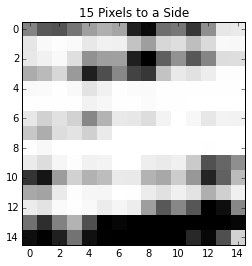

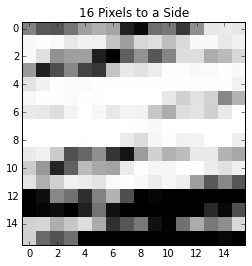

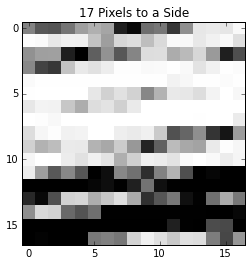

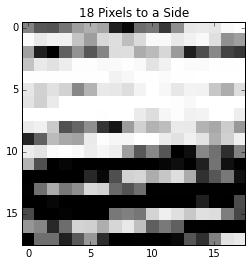

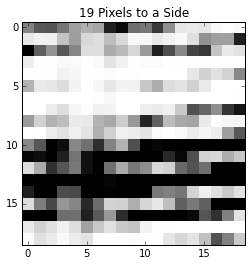

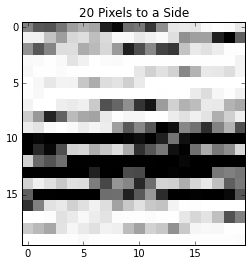

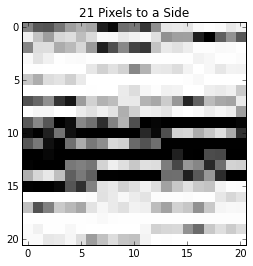

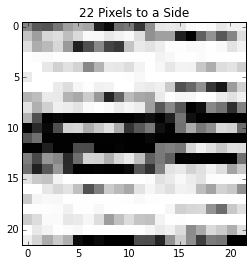

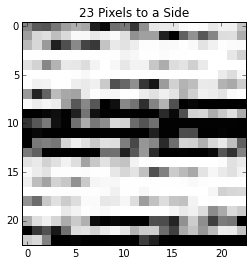

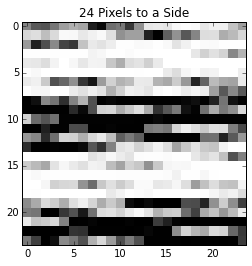

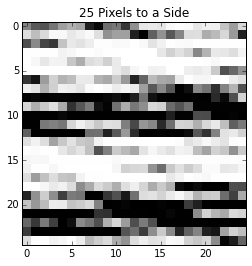

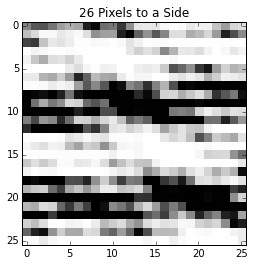

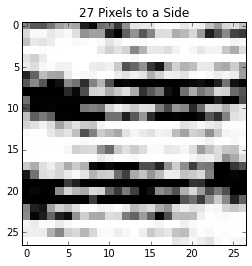

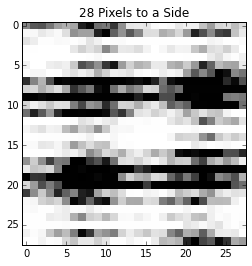

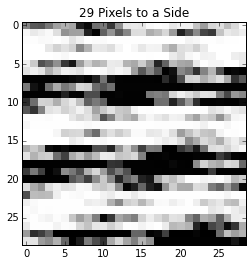

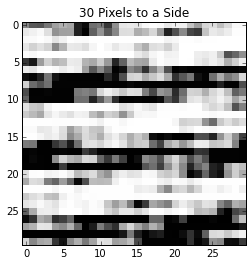

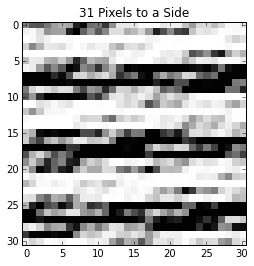

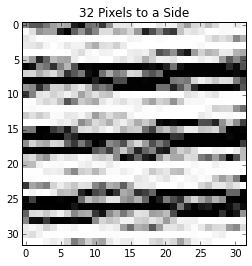

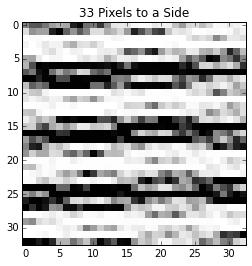

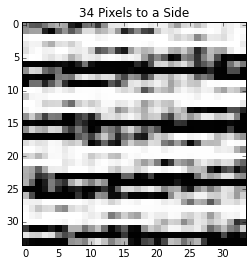

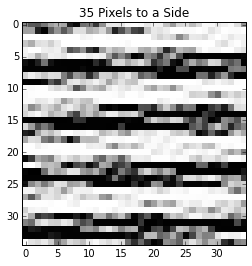

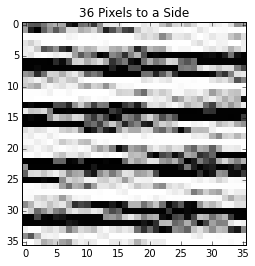

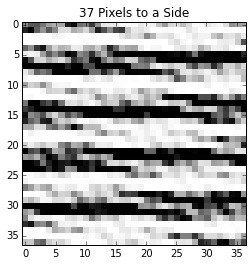

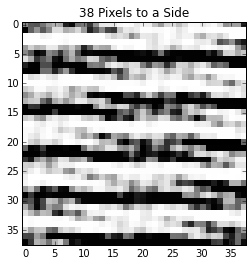

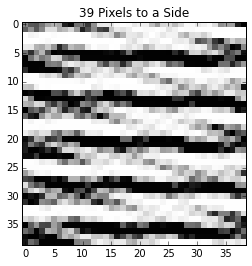

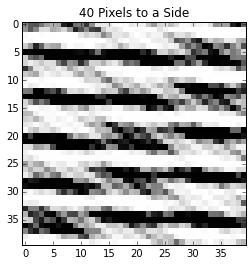

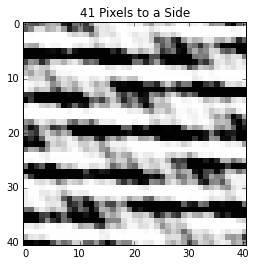

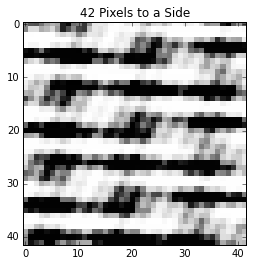

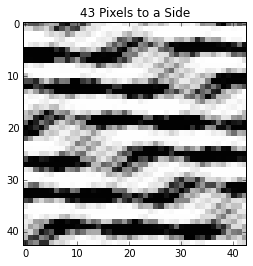

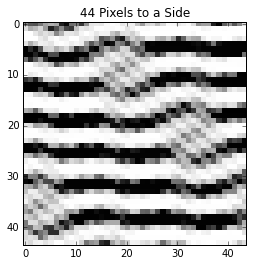

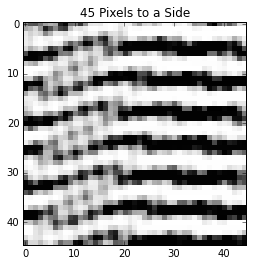

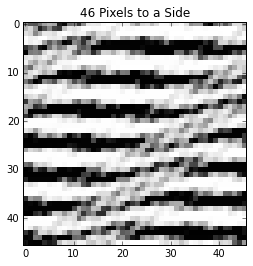

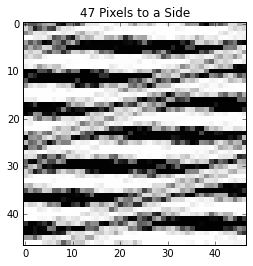

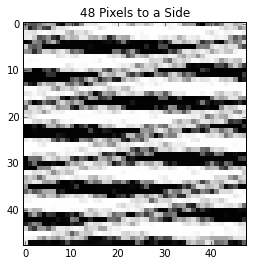

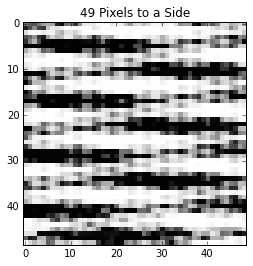

In [40]:
for el in range(15, 50):
    fig, ax = plt.subplots()
    plt.imshow(dd[:el**2].reshape((el,)*2), cmap='gray',
              interpolation = 'nearest')
    plt.title('{} Pixels to a Side'.format(el))